## Libraries

# Grid Graph construction and 

In [2]:
from queries import*
from utilities import*
from scipy.spatial import Delaunay
from numpy import linalg
from sklearn import preprocessing
import copy
from pathlib import Path

In [3]:
'''def add_edge_to_graph(G, e1, e2, w):
    G.add_edge(e1, e2)


G = nx.Graph()
points = list(unique_patchs)  # (x,y) points
edges = [(0, 1, 10), (1, 2, 5), (2, 3, 25), (0, 3, 3), (3, 4, 8)]  # (v1,v2, weight)

for i in range(len(edges)):
    add_edge_to_graph(G, points[edges[i][0]], points[edges[i][1]], edges[i][2])

# you want your own layout
# pos = nx.spring_layout(G)
pos = {point: point for point in points}

# add axis
fig, ax = plt.subplots()
nx.draw(G, pos=pos, node_color='k', ax=ax)
nx.draw(G, pos=pos, node_size=1500, ax=ax)  # draw nodes and edges
nx.draw_networkx_labels(G, pos=pos)  # draw node labels/names
# draw edge weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
plt.axis("on")
ax.set_xlim(0, 11)
ax.set_ylim(0,11)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()
'''

'def add_edge_to_graph(G, e1, e2, w):\n    G.add_edge(e1, e2)\n\n\nG = nx.Graph()\npoints = list(unique_patchs)  # (x,y) points\nedges = [(0, 1, 10), (1, 2, 5), (2, 3, 25), (0, 3, 3), (3, 4, 8)]  # (v1,v2, weight)\n\nfor i in range(len(edges)):\n    add_edge_to_graph(G, points[edges[i][0]], points[edges[i][1]], edges[i][2])\n\n# you want your own layout\n# pos = nx.spring_layout(G)\npos = {point: point for point in points}\n\n# add axis\nfig, ax = plt.subplots()\nnx.draw(G, pos=pos, node_color=\'k\', ax=ax)\nnx.draw(G, pos=pos, node_size=1500, ax=ax)  # draw nodes and edges\nnx.draw_networkx_labels(G, pos=pos)  # draw node labels/names\n# draw edge weights\nlabels = nx.get_edge_attributes(G, \'weight\')\nnx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)\nplt.axis("on")\nax.set_xlim(0, 11)\nax.set_ylim(0,11)\nax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)\nplt.show()\n'

## Parameters

In [4]:
base_directory = Path(Path.cwd()).parent
PATIENT_ID = '1C1'
INPUT =   os.path.join(base_directory,'data','input')
OUTPUT =   os.path.join(base_directory,'data','output')
INPUT_PATH = os.path.join(INPUT,'DEEPMEL_' + PATIENT_ID + '\\')
OUTPUT_PATH = os.path.join(OUTPUT,'DEEPMEL_' + PATIENT_ID + '\\')

PLOT_DIRECTORY = os.path.join(base_directory,'plots')
PLOT_PATH = os.path.join(PLOT_DIRECTORY, 'DEEPMEL_' + PATIENT_ID)
INPUT_FILE = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data.csv'
TABLE_NAME_BQ = 'DEEPMEL_'+ PATIENT_ID +'_cell_seg_data'
EPSILONE  = 25
THRESHOLD = 35

PATCH_DIM_X = 1000
PATCH_DIM_Y = 1000
SIZE_THRESHOLD = 500
NORMALISE_COUNT = False

## Read nodes

In [5]:
nodes = pd.read_csv(OUTPUT_PATH+'nodes_with_border.csv')

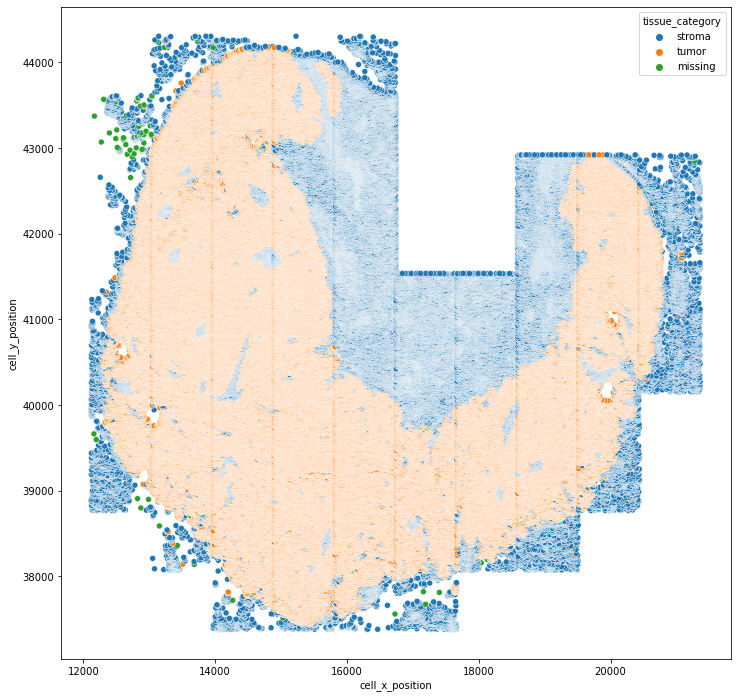

In [6]:
fig, ax = plt.subplots(figsize = (12,12))
sns.scatterplot(data = nodes , x='cell_x_position', y= 'cell_y_position',hue='tissue_category').get_figure().savefig(PLOT_PATH+'All_tissue.png');

In [7]:
nodes.head()

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border
0,1,14040.7,37383.4,stroma,stroma,False
1,2,14049.6,37381.9,stroma,MISSING,False
2,3,14056.5,37381.9,stroma,MISSING,False
3,4,14088.8,37381.9,stroma,MISSING,False
4,5,14114.1,37382.4,stroma,MISSING,False


In [8]:
nodes_sorted_x = nodes.sort_values(['cell_x_position'])

In [9]:
shifted_x = nodes_sorted_x['cell_x_position'] - min(nodes_sorted_x['cell_x_position'])
nodes_sorted_x['patch_x'] = shifted_x//PATCH_DIM_X

In [10]:
nodes_sorted_y = nodes_sorted_x.sort_values(['cell_y_position'])
shifted_y = nodes_sorted_y['cell_y_position'] - min(nodes_sorted_y['cell_y_position'])
nodes_sorted_y['patch_y'] = shifted_y//PATCH_DIM_Y

In [11]:
nodes_sorted_y['patch'] = nodes_sorted_y.apply(lambda row: (row.patch_x,row.patch_y), axis=1)

In [12]:
#fig, ax = plt.subplots(figsize = (15,15))
#unique = nodes_sorted_y["patch"].unique()
#palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
#color = random.shuffle(sns.color_palette())
#sns.scatterplot(data = nodes_sorted_y , x='cell_x_position', y= 'cell_y_position', hue = 'patch', palette =palette)
#plt.savefig('./plots/patches_'+PATIENT_ID+'.png')

In [13]:
columns = ['cell_id','patch']
patch_mapping = nodes_sorted_y[columns]

# Size patches

In [14]:
patch_sizes = pd.DataFrame(patch_mapping.patch.value_counts()).reset_index().rename(columns = {'index':'patch','patch':'patch_size'})

In [15]:
patch_mapping = patch_mapping.merge(patch_sizes, on='patch', how = 'left')

In [16]:
nodes_sorted_y['patch_size'] = patch_mapping['patch_size']

In [17]:
nodes = nodes_sorted_y.drop(['patch_x','patch_y'],axis=1)

In [18]:
nodes.head(2)

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border,patch,patch_size
3,4,14088.8,37381.9,stroma,MISSING,False,"(1.0, 0.0)",3883
1,2,14049.6,37381.9,stroma,MISSING,False,"(1.0, 0.0)",573


In [19]:
del nodes_sorted_x
del nodes_sorted_y

# Read edges

In [20]:
edges = pd.read_csv(OUTPUT_PATH + 'graph_edges.csv')

In [21]:
edges = edges.merge(patch_mapping , left_on = 'cell_id_1', right_on = 'cell_id', how='left')
edges = edges.merge(patch_mapping , left_on = 'cell_id_2', right_on = 'cell_id', how='left')

In [22]:
edges = edges.drop(['cell_id_x','cell_id_y','patch_size_y'], axis =1)
edges = edges.rename(columns={'patch_x':'patch_1','patch_y':'patch_2','patch_size_x':'patch_size'})

In [23]:
inter_patch = (edges.patch_1 != edges.patch_2).value_counts()[False]
intra_patch = (edges.patch_1 != edges.patch_2).value_counts()[True]
print('inter-patch edges: ',inter_patch )
print('intra-patch edges: ',intra_patch )

inter-patch edges:  2071075
intra-patch edges:  38635


In [24]:
edges = edges[(edges.patch_1 == edges.patch_2)]
edges = edges.drop(['patch_2'], axis =1)
edges = edges.rename(columns ={'patch_1' : 'patch'})

# Patch filtering 

In [25]:
nodes = nodes[nodes.patch_size>SIZE_THRESHOLD]
edges = edges[edges.patch_size>SIZE_THRESHOLD]

In [26]:
unique_patchs = nodes.groupby(['patch']).agg('count').reset_index()['patch'].values
patch_number = pd.DataFrame({'patch':unique_patchs, 'patch_number': range(len(unique_patchs))})

In [27]:
nodes = nodes.merge(patch_number, on='patch', how='left')

In [28]:
edges = edges.merge(patch_number, on='patch', how='left')

# Plotting Grid Graph

## Localisation patches

In [29]:
localisation_columns = ['patch_number','patch', 'cell_x_position','cell_y_position']
localisation_nodes = nodes[localisation_columns]
localisation_patch = localisation_nodes.groupby(['patch']).agg('mean').reset_index()

## Number of border cells

In [30]:
border_grouped = nodes.groupby(['patch','on_border']).agg('count')['cell_id'].reset_index().rename(columns = {'cell_id':'count'})
on_border_grouped_pivotted = pd.pivot_table(border_grouped, values='count', index=['patch'],columns=['on_border'], aggfunc=np.sum).reset_index()
on_border_grouped_pivotted.columns.name = None
on_border_grouped_pivotted = on_border_grouped_pivotted.fillna(0)
on_border_grouped_pivotted = on_border_grouped_pivotted.rename(columns = {False:'out_of_border',True:'in_border'})


In [31]:
patch_data = localisation_patch.merge(on_border_grouped_pivotted, on='patch', how='left')

# Edge count per patch

In [32]:
edges = edges[(edges.phenotype_1 != 'MISSING') & (edges.phenotype_2 != 'MISSING')]

edge_phenotype_count = edges.groupby(['patch','phenotype_1','phenotype_2']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'edge_count'})

number_per_patch = edges.groupby(['patch']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'total_edge_per_patch'})

edge_phenotype_count = edge_phenotype_count.merge(number_per_patch,on='patch',how='left')

if NORMALISE_COUNT == True :
    edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']/edge_phenotype_count['total_edge_per_patch']

if NORMALISE_COUNT == False :
    edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']

    
edge_phenotype_count['edge_type'] = edge_phenotype_count.apply(lambda row : order_phenotypes(row.phenotype_1,row.phenotype_2), axis=1)

edge_phenotype_count = edge_phenotype_count[['patch','edge_count_ratio','edge_type']]


edge_phenotype_count_pivotted = pd.pivot_table(edge_phenotype_count, values='edge_count_ratio', index=['patch'],
                    columns=['edge_type'], aggfunc=np.sum)

edge_phenotype_count_pivotted.columns.name = None
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.reset_index()
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)

columns = edge_phenotype_count_pivotted.columns[1:]


In [33]:
patch_data = patch_data.merge(edge_phenotype_count_pivotted, on='patch', how='left')

## Nodes regions  phenotype count

In [34]:
nodes['region'] = nodes.apply(lambda x : regions(x.tissue_category, x.on_border), axis =1)
nodes_grouped = nodes.groupby(['patch','region','phenotype']).agg('count')['cell_id'].reset_index().rename(columns = {'cell_id':'count'})
nodes_grouped['region_phenotype'] = nodes_grouped.apply(lambda row: row.region + '_region_' + row.phenotype , axis = 1)
nodes_grouped = nodes_grouped.merge(patch_sizes, on='patch', how ='left')
if NORMALISE_COUNT == True:
    nodes_grouped['count'] = nodes_grouped['count']/nodes_grouped['patch_size']
region_count_grouped_pivotted = pd.pivot_table(nodes_grouped, values='count', index=['patch'],columns=['region_phenotype'], aggfunc=np.sum).reset_index()
region_count_grouped_pivotted.columns.name = None
region_count_grouped_pivotted = region_count_grouped_pivotted.fillna(0)



In [35]:
patch_data = patch_data.merge(region_count_grouped_pivotted, on='patch', how='left')

In [36]:
patch_data.fillna(0)

,patch,patch_number,cell_x_position,cell_y_position,out_of_border,in_border,B-B,DP1-B,DP1-DP1,T-B,...,stroma_region_tumor,tumor_region_B,tumor_region_DP1,tumor_region_MISSING,tumor_region_NK,tumor_region_T,tumor_region_dendtritic,tumor_region_macrophages,tumor_region_stroma,tumor_region_tumor
0,"(0.0, 0.0)",0,13065.950000,38148.250000,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(0.0, 1.0)",1,12707.829599,39174.570098,1152.0,169.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,13.0,1.0,1.0,0.0,0.0,46.0,506.0
2,"(0.0, 2.0)",2,12735.697632,39906.461461,4526.0,1512.0,96.0,0.0,0.0,258.0,...,0.0,1.0,0.0,75.0,3.0,5.0,0.0,5.0,399.0,3555.0
3,"(0.0, 3.0)",3,12769.652418,40870.311821,5333.0,1037.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,68.0,0.0,2.0,0.0,11.0,562.0,4442.0
4,"(0.0, 4.0)",4,12903.813806,41821.793532,3513.0,507.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,82.0,1.0,3.0,0.0,5.0,342.0,2919.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,"(8.0, 5.0)",56,20417.292615,42585.889104,1299.0,353.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,59.0,691.0
57,"(9.0, 2.0)",57,21253.314085,40262.319718,142.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,"(9.0, 3.0)",58,21247.484861,40827.790832,469.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,"(9.0, 4.0)",59,21242.214983,41963.329965,287.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
patch_data.to_csv(OUTPUT_PATH + 'patch_data.csv', index = False)

In [38]:
patch_data.iloc[:, : 21].head()

,patch,patch_number,cell_x_position,cell_y_position,out_of_border,in_border,B-B,DP1-B,DP1-DP1,T-B,...,T-T,dendtritic-B,dendtritic-DP1,dendtritic-T,dendtritic-dendtritic,macrophages-B,macrophages-T,macrophages-dendtritic,macrophages-macrophages,stroma-B
0,"(0.0, 0.0)",0,13065.950000,38148.250000,2.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(0.0, 1.0)",1,12707.829599,39174.570098,1152.0,169.0,1.0,0.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0
2,"(0.0, 2.0)",2,12735.697632,39906.461461,4526.0,1512.0,96.0,0.0,0.0,258.0,...,323.0,32.0,0.0,68.0,31.0,0.0,5.0,0.0,2.0,138.0
3,"(0.0, 3.0)",3,12769.652418,40870.311821,5333.0,1037.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0
4,"(0.0, 4.0)",4,12903.813806,41821.793532,3513.0,507.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [39]:
patch_data.iloc[:, 21: ].head()

,stroma-DP1,stroma-T,stroma-dendtritic,stroma-macrophages,stroma-stroma,tumor-B,tumor-DP1,tumor-T,tumor-dendtritic,tumor-macrophages,...,stroma_region_tumor,tumor_region_B,tumor_region_DP1,tumor_region_MISSING,tumor_region_NK,tumor_region_T,tumor_region_dendtritic,tumor_region_macrophages,tumor_region_stroma,tumor_region_tumor
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,44.0,0.0,68.0,866.0,0.0,0.0,17.0,0.0,6.0,...,0.0,0.0,0.0,13.0,1.0,1.0,0.0,0.0,46.0,506.0
2,0.0,493.0,30.0,89.0,2010.0,76.0,0.0,175.0,13.0,73.0,...,0.0,1.0,0.0,75.0,3.0,5.0,0.0,5.0,399.0,3555.0
3,0.0,65.0,0.0,86.0,1624.0,12.0,0.0,35.0,0.0,109.0,...,0.0,0.0,0.0,68.0,0.0,2.0,0.0,11.0,562.0,4442.0
4,0.0,36.0,0.0,45.0,703.0,0.0,0.0,53.0,0.0,75.0,...,0.0,0.0,0.0,82.0,1.0,3.0,0.0,5.0,342.0,2919.0


# Defining Grid Graph

In [40]:
edges_data = patch_data[['patch_number','patch']].copy()
edges_data['key'] = 0

edges_data = edges_data.merge(edges_data, how = 'left', on = 'key')

edges_data['distance'] = edges_data.apply(lambda row: np.linalg.norm(np.array(row.patch_x) - np.array(row.patch_y)), axis=1)

edges_data = edges_data[edges_data['distance'] == 1]

edges_data = edges_data.drop(['key'], axis=1)
edges_data = edges_data.rename(columns={'patch_number_x':'patch_number_1','patch_x':'patch_1','patch_number_y':'patch_number_2','patch_y':'patch_2'})

edges_data.head(2)


,patch_number_1,patch_1,patch_number_2,patch_2,distance
1,0,"(0.0, 0.0)",1,"(0.0, 1.0)",1.0
7,0,"(0.0, 0.0)",7,"(1.0, 0.0)",1.0


In [41]:
len(edges_data)

208

In [42]:
edges_data.to_csv(OUTPUT_PATH + 'patch_edge_data.csv', index = False)

# extracting for all Patients

In [43]:
INPUT =   os.path.join(base_directory,'data','input')
OUTPUT =   os.path.join(base_directory,'data','output')
files = os.listdir(OUTPUT)
columns_list = []
for file in files[:]:
    
    array = file.split('_')
    if len(array)==2:
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition = ''
        
    
    if condition == 'DEEPMEL':
        patch_features_df = pd.read_csv(os.path.join(OUTPUT,file + '\\patch_data.csv'))
        columns = patch_features_df.columns
        for column in columns :
            if ((len(column.split('_'))==2) and (column.split('_')[0] == 'missing')) or ((len(column.split('_'))==3) and (column.split('_')[2] =='MISSING')) or (column =='Unnamed: 0') or  (column =='Unnamed: 0.1') or (len(column.split('_'))==3) and (column.split('_')[0] == 'missing') :
                patch_features_df = patch_features_df.drop([column], axis =1) 
                print('column : ' + column +' dropped ')
                
    
                
        columns = patch_features_df.columns

        
        print('Patient : '+ PATIENT_ID +' n_features :', len(columns))
        columns_list = Union(columns_list,columns)

        patch_features_df.to_csv(os.path.join(OUTPUT,file + '\\patch_data_1.csv'))

    else:
        continue

column : border_region_MISSING dropped 
column : missing_region_MISSING dropped 
column : missing_region_T dropped 
column : missing_region_stroma dropped 
column : stroma_region_MISSING dropped 
column : tumor_region_MISSING dropped 
Patient : 1C1 n_features : 56
column : Unnamed: 0 dropped 
column : missing_region_DP1 dropped 
column : missing_region_NK dropped 
column : missing_region_T dropped 
column : missing_region_stroma dropped 
column : missing_region_tumor dropped 
Patient : 1C5 n_features : 37
column : Unnamed: 0 dropped 
column : missing_region_T dropped 
column : missing_region_stroma dropped 
Patient : 1D1 n_features : 57
column : Unnamed: 0 dropped 
column : missing_region_B dropped 
column : missing_region_T dropped 
column : missing_region_stroma dropped 
column : missing_region_tumor dropped 
Patient : 1E1 n_features : 57
column : Unnamed: 0 dropped 
column : missing_region_T dropped 
column : missing_region_stroma dropped 
Patient : 1F1 n_features : 57
column : Unna

In [44]:
OUTPUT =   os.path.join(base_directory,'data','output')
files = os.listdir(OUTPUT)
for file in files[:]:
    
    array = file.split('_')
    if len(array)==2:
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition = ''
        
    
    if condition == 'DEEPMEL':
        
        patch_features_df = pd.read_csv(os.path.join(OUTPUT,file + '\\patch_data_1.csv'), index_col=[0])
        columns_df = patch_features_df.columns
        for column in columns_list:
            if not(column in columns_df):
                patch_features_df[column] = 0
                
        columns_df = patch_features_df.columns
            
        print('Patient : '+PATIENT_ID +' n_features :', len(columns_df)) 
        patch_features_df.to_csv(os.path.join(OUTPUT,file + '\\patch_data_1.csv'), index = False)


Patient : 1C1 n_features : 68
Patient : 1C5 n_features : 68
Patient : 1D1 n_features : 68
Patient : 1E1 n_features : 68
Patient : 1F1 n_features : 68
Patient : 1J1 n_features : 68
Patient : 1J2 n_features : 68
Patient : 1K1 n_features : 68
Patient : 1L1 n_features : 68
Patient : 1M1 n_features : 68
Patient : 1N1 n_features : 68
Patient : 1O1 n_features : 68
Patient : 1O2 n_features : 68
Patient : 1P1 n_features : 68
Patient : 1R1 n_features : 68
Patient : 1R2 n_features : 68
Patient : 1S1 n_features : 68
Patient : 1S2 n_features : 68
Patient : 1U1 n_features : 68
Patient : 1V1 n_features : 68
Patient : 1V2 n_features : 68
Patient : 1W1 n_features : 68
Patient : 1X1 n_features : 68
Patient : 1X2 n_features : 68
Patient : 1X3 n_features : 68
Patient : 1Y1 n_features : 68
Patient : 1Z2 n_features : 68
Patient : 2A1 n_features : 68
Patient : 2B1 n_features : 68
Patient : 2B2 n_features : 68
Patient : 2C1 n_features : 68
Patient : 2D1 n_features : 68
Patient : 2D2 n_features : 68
Patient : 

In [45]:
patch_features_df = pd.read_csv(OUTPUT+'\\DEEPMEL_1C1\\patch_data_1.csv', index_col=[0])

In [46]:
len(patch_features_df)

61

In [49]:
columns_list.append('patient_id')

In [68]:
files = os.listdir(OUTPUT)
sum_stats = pd.DataFrame (columns = columns_list)
for file in files[:]:
    
    array = file.split('_')
    if len(array)==2:
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition = ''
        
    
    if condition == 'DEEPMEL':
        
        patch_features_df = pd.read_csv(os.path.join(OUTPUT,file)+'\\patch_data_1.csv', index_col=[0])
        columns_of_df = patch_features_df.columns
        statistics = pd.DataFrame(columns=columns_of_df)
        mins = patch_features_df.min()
        statistics = statistics.append(mins,ignore_index=True)
        maxs = patch_features_df.max()
        statistics = statistics.append(maxs,ignore_index=True)
        #statistics.drop['cell_x_position','cell_y_position']
        statistics['patient_id']=PATIENT_ID
        #statistics.insert(1,'patient_id', PATIENT_ID)
        sum_stats = sum_stats.append(statistics, ignore_index=True)
        sum_stats.fillna(0)
        #for column in columns_of_df:
            #statistics = patch_features_df.min()
        #print(PATIENT_ID + ':', len(patch_features_df))


In [76]:
sum_stats = sum_stats.drop('patch_number', axis = 1)

In [77]:
sum_stats

,DP2-B,DP2-DP2,tumor_region_B,macrophages-T,stroma_region_tumor,stroma-T,dendtritic-DP2,DP2-DP1,stroma_region_stroma,stroma_region_dendtritic,...,B-B,tumor_region_DP1,stroma_region_DP1,T-DP2,tumor_region_DP2,stroma-DP1,border_region_dendtritic,tumor-T,dendtritic-T,patient_id
0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1C1
1,0.0,0.0,3.0,31.0,478.0,4907.0,0.0,0.0,3738.0,2169.0,...,2204.0,4.0,24.0,0.0,0.0,86.0,19.0,3607.0,3246.0,1C1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1C5
3,0.0,0.0,2.0,0.0,27.0,1162.0,0.0,0.0,5336.0,0.0,...,85.0,2.0,2.0,0.0,0.0,126.0,0.0,679.0,0.0,1C5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1D1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,10.0,4.0,42.0,200.0,222.0,5268.0,0.0,0.0,1522.0,0.0,...,9577.0,274.0,3.0,23.0,0.0,443.0,0.0,10516.0,0.0,4Q1
166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4R1
167,2.0,1.0,0.0,15.0,384.0,365.0,0.0,0.0,4429.0,0.0,...,446.0,2.0,1.0,6.0,0.0,734.0,0.0,532.0,0.0,4R1
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4S1


In [88]:
sum_stats.columns

Index(['DP2-B', 'DP2-DP2', 'tumor_region_B', 'macrophages-T',
       'stroma_region_tumor', 'stroma-T', 'dendtritic-DP2', 'DP2-DP1',
       'stroma_region_stroma', 'stroma_region_dendtritic', 'tumor-DP1',
       'macrophages-macrophages', 'DP1-B', 'tumor-B', 'dendtritic-DP1',
       'border_region_DP2', 'tumor_region_T', 'border_region_tumor',
       'tumor-DP2', 'dendtritic-B', 'macrophages-DP1', 'stroma_region_DP2',
       'border_region_macrophages', 'tumor_region_stroma', 'cell_x_position',
       'stroma-B', 'macrophages-DP2', 'tumor-macrophages', 'T-DP1',
       'tumor_region_dendtritic', 'tumor-stroma', 'tumor-dendtritic',
       'stroma-macrophages', 'stroma_region_macrophages', 'border_region_B',
       'stroma-stroma', 'tumor-tumor', 'tumor_region_NK', 'cell_y_position',
       'T-T', 'macrophages-dendtritic', 'border_region_DP1', 'DP1-DP1',
       'border_region_stroma', 'stroma_region_B', 'dendtritic-dendtritic',
       'T-B', 'tumor_region_tumor', 'macrophages-B', 'in_bord

In [86]:
phenotype = []
for column in sum_stats.columns:
    if (len(column.split('_'))==3) and (column.split('_')[1] == 'region'):
        phenotype.append(column)
phenotype_densities = sum_stats.loc[:,phenotype]

In [87]:
phenotype_densities

,tumor_region_B,stroma_region_tumor,stroma_region_stroma,stroma_region_dendtritic,border_region_DP2,tumor_region_T,border_region_tumor,stroma_region_DP2,border_region_macrophages,tumor_region_stroma,...,stroma_region_B,tumor_region_tumor,stroma_region_NK,stroma_region_T,tumor_region_macrophages,border_region_T,tumor_region_DP1,stroma_region_DP1,tumor_region_DP2,border_region_dendtritic
0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,478.0,3738.0,2169.0,0.0,58.0,1457.0,0.0,18.0,623.0,...,703.0,9105.0,24.0,2165.0,11.0,362.0,4.0,24.0,0.0,19.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,27.0,5336.0,0.0,0.0,32.0,5690.0,0.0,0.0,1614.0,...,30.0,9681.0,46.0,86.0,0.0,177.0,2.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,42.0,222.0,1522.0,0.0,2.0,223.0,5415.0,5.0,38.0,1378.0,...,1561.0,9923.0,47.0,1842.0,13.0,1448.0,274.0,3.0,0.0,0.0
166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,0.0,384.0,4429.0,0.0,0.0,5.0,1617.0,4.0,2.0,265.0,...,161.0,2858.0,2411.0,85.0,0.0,24.0,2.0,1.0,0.0,0.0
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
sum_stats_max = sum_stats.max()

In [81]:
sum_stats_max

DP2-B                         341
DP2-DP2                       685
tumor_region_B               1432
macrophages-T                2870
stroma_region_tumor          8552
                            ...  
stroma-DP1                   3702
border_region_dendtritic     1707
tumor-T                     38302
dendtritic-T                25346
patient_id                    4S1
Length: 67, dtype: object

In [106]:
edges = []
for column in sum_stats.columns:
    if not (((len(column.split('_'))==3) and (column.split('_')[1] == 'region')) or (column == 'patient_id')):
        edges.append(column)
edge_count = sum_stats.loc[:,edges]

In [107]:
edge_count

,DP2-B,DP2-DP2,macrophages-T,stroma-T,dendtritic-DP2,DP2-DP1,tumor-DP1,macrophages-macrophages,DP1-B,tumor-B,...,macrophages-B,in_border,out_of_border,stroma-dendtritic,stroma-DP2,B-B,T-DP2,stroma-DP1,tumor-T,dendtritic-T
0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,31.0,4907.0,0.0,0.0,98.0,87.0,24.0,1121.0,...,6.0,2461.0,9653.0,5431.0,0.0,2204.0,0.0,86.0,3607.0,3246.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1162.0,0.0,0.0,15394.0,0.0,0.0,54.0,...,0.0,13764.0,25649.0,0.0,0.0,85.0,0.0,126.0,679.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,10.0,4.0,200.0,5268.0,0.0,0.0,2907.0,85.0,21.0,4331.0,...,19.0,9577.0,10788.0,0.0,5.0,9577.0,23.0,443.0,10516.0,0.0
166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,2.0,1.0,15.0,365.0,0.0,0.0,8336.0,122.0,0.0,138.0,...,0.0,5987.0,23688.0,0.0,21.0,446.0,6.0,734.0,532.0,0.0
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
#edge_count = edge_count.drop('sum', axis = 1)

In [113]:
edge_count_percentage  =  100 * edge_count[edges].div(edge_count[edges].sum(axis=1), axis=0)

In [115]:
pd.set_option('display.max_columns', None)

In [116]:
edge_count_percentage

,DP2-B,DP2-DP2,macrophages-T,stroma-T,dendtritic-DP2,DP2-DP1,tumor-DP1,macrophages-macrophages,DP1-B,tumor-B,dendtritic-DP1,tumor-DP2,dendtritic-B,macrophages-DP1,cell_x_position,stroma-B,macrophages-DP2,tumor-macrophages,T-DP1,tumor-stroma,tumor-dendtritic,stroma-macrophages,stroma-stroma,tumor-tumor,cell_y_position,T-T,macrophages-dendtritic,DP1-DP1,dendtritic-dendtritic,T-B,macrophages-B,in_border,out_of_border,stroma-dendtritic,stroma-DP2,B-B,T-DP2,stroma-DP1,tumor-T,dendtritic-T
0,0.000000,0.000000,0.000000,0.031338,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.723245,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.897054,0.000000,74.342487,0.001959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.014635,2.316571,0.0,0.0,0.046265,0.041072,0.011330,0.529219,0.013219,0.000000,0.226134,0.000000,10.049842,0.716640,0.000000,0.054291,0.033519,3.895729,0.52497,0.153431,3.913668,36.604836,20.658875,3.746074,0.022188,0.008026,1.948336,1.869024,0.002833,1.161826,4.557134,2.563948,0.000000,1.040498,0.000000,0.040600,1.702847,1.532421
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.871344,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,94.118136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.154276,0.0,0.0,2.043832,0.000000,0.000000,0.007169,0.000000,0.000000,0.000000,0.000000,2.505617,0.033325,0.000000,0.000000,0.000133,3.621382,0.00000,0.000000,15.389810,60.471205,7.885236,0.052974,0.000000,2.460989,0.000000,0.023102,0.000000,1.827420,3.405368,0.000000,0.000000,0.011285,0.000000,0.016729,0.090150,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.984470,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,78.910557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.003740,0.001496,0.074796,1.970115,0.0,0.0,1.087153,0.031788,0.007854,1.619698,0.000000,0.004114,0.000000,0.001496,8.407784,1.135396,0.001496,0.086389,0.043381,10.612741,0.00000,0.087137,2.988830,31.580926,19.955281,3.531472,0.000000,0.091251,0.000000,1.362027,0.007106,3.581585,4.034472,0.000000,0.001870,3.581585,0.008601,0.165672,3.932750,0.000000
166,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.503821,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.076911,0.000000,79.416063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
167,0.000335,0.000168,0.002513,0.061149,0.0,0.0,1.396533,0.020439,0.000000,0.023119,0.000000,0.002178,0.000000,0.000000,4.173542,0.116769,0.001675,0.007874,0.000000,5.491980,0.00000,0.150610,16.582824,50.601035,10.178408,0.040542,0.000000,5.868756,0.000000,0.016753,0.000000,1.003004,3.968459,0.000000,0.003518,0.074719,0.001005,0.122967,0.089126,0.000000
168,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.632891,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,79.362077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Plotting GRID GRAPHS

In [117]:
OUTPUT =   os.path.join(base_directory,'data','output')
print(OUTPUT)
PATIENT_ID = '1R1'
patch_features_df = pd.read_csv(os.path.join(OUTPUT,'DEEPMEL_'+ PATIENT_ID ,'patch_data_1.csv'), index_col=[0])
patch_edges = pd.read_csv(OUTPUT+'\\DEEPMEL_'+ PATIENT_ID +'\\patch_edge_data.csv')

D:\EPFL\data\output


In [118]:
import re
def get_coordinates(string):
    a , b = string.split(',')
    
    pattern = r'[() ]'
    
    a = int(re.sub(pattern, '', a).split('.')[0])
    b = int(re.sub(pattern, '', b).split('.')[0])
    
    return a,b

In [121]:
#patch_features_df['patch']= patch_features_df['patch'].apply(lambda x: get_coordinates(x))

In [123]:
#points = patch_features_df.patch.values

In [122]:
#patch_edges_ = patch_edges[patch_edges.patch_number_1 <patch_edges.patch_number_2]

In [ ]:
edges = []
for index, row in patch_edges.iterrows():
    edges.append((row.patch_number_1,row.patch_number_2))
    
    

In [ ]:
def add_edge_to_graph(G, e1, e2):
    G.add_edge(e1, e2)


G = nx.Graph()
  # (v1,v2, weight)

for i in range(len(edges)):
    add_edge_to_graph(G, points[edges[i][0]], points[edges[i][1]])

# you want your own layout
# pos = nx.spring_layout(G)
pos = {point: point for point in points}

# add axis
fig, ax = plt.subplots(figsize = (20,20))
nx.draw(G, pos=pos, node_color='k', ax=ax)
nx.draw(G, pos=pos, node_size=1500, ax=ax)  # draw nodes and edges
nx.draw_networkx_labels(G, pos=pos)  # draw node labels/names
# draw edge weights
plt.axis("on")
plt.xlabel('Patch X label')
plt.ylabel('Patch Y label')
plt.title(PATIENT_ID +' Grid Graph')
PLOT_PATH = os.path.join(PLOT_DIRECTORY, 'DEEPMEL_' + PATIENT_ID)
if not os.path.exists(PLOT_PATH):
    os.mkdir(PLOT_PATH)
plt.savefig(PLOT_PATH+'\\grid_graph.png')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()